In [1]:
import numpy as np
import pylab as plt
import networkx as nx
import osmnx as ox
import pickle
import wandb
import random
import math

In [ ]:
!wandb login
wandb.init(project="Boston")

In [2]:
import matplotlib.pyplot as plt
place_name = "Boston, United States" 
graph = ox.graph_from_place(place_name)

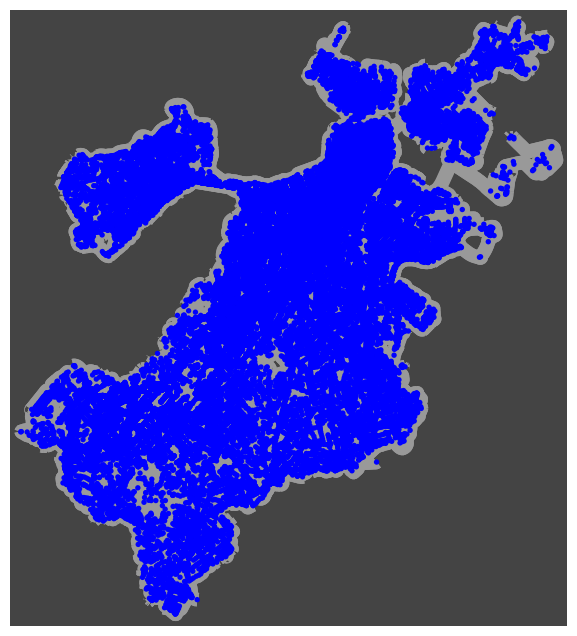

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [4]:
ox.plot.plot_graph(graph, ax=None, figsize=(8, 8), bgcolor='#444444', node_color='b', node_size=15, node_alpha=None, node_edgecolor='none', node_zorder=1, edge_color='#999999', edge_linewidth=10, edge_alpha=None, show=True, close=False, save=False, filepath=None, dpi=300, bbox=None)

In [5]:
nodes_list = list(graph.nodes())
len(nodes_list)

54746

In [6]:
MATRIX_SIZE = len(nodes_list)

# create matrix x*y
R = np.ones(shape=(MATRIX_SIZE, MATRIX_SIZE))
R *= -1
R

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [7]:
adjmatrix = nx.to_numpy_array(graph)
adjmatrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
nodec = ox.nearest_nodes(graph,-71.078096, 42.331018)
carol_pos = nodes_list.index(nodec)
#Carol

In [ ]:
nodeps = ox.nearest_nodes(graph, -71.089165, 42.351355)
paul_start = nodes_list.index(nodeps)
#Paul Start

In [ ]:
nodepe = ox.nearest_nodes(graph, -71.139223, 42.233716)
paul_end = nodes_list.index(nodepe)
#end of grid

In [ ]:
for i in range(0, len(adjmatrix)):
    for j in range(0, len(adjmatrix)):
        if adjmatrix[i][j] > 0.0:
            R[i][j] = 0
R[paul_end, paul_end] = 1000
R[carol_pos, carol_pos] = -1000000000000000000000000000000000000000000000000

In [ ]:
# Here we initialize our Q-learning Matrix
Q = np.matrix(np.zeros([len(nodes_list), len(nodes_list)]))

# learning parameter
gamma = 0.965

initial_state = 1
previous_state = 0

#---------------------------------------------------------------
# Given a particular state we want to know what the available actions that we can do
def available_actions_2(state):
    current_state_row = R_2[state,]
    av_act = np.where(current_state_row >= 0)[0]
    return av_act

def available_actions(state):
    current_state_row = R[state,]
    av_act = np.where(current_state_row >= 0)[0]
    return av_act

available_act = available_actions(initial_state) 

#---------------------------------------------------------------
# Given a range of available action we want to sample the next action that we can do
def sample_next_action(available_actions_range, previous_state, state):
    if available_actions_range.size == 0:
        #print("reached")
        available_actions_range = np.setdiff1d(available_actions(previous_state), state)
        print(available_actions_range)
        next_action = int(np.random.choice(available_actions_range,1))
    else:
        next_action = int(np.random.choice(available_actions_range,1))
    return next_action

action = sample_next_action(available_act, previous_state, initial_state)

#---------------------------------------------------------------

def update(current_state, action, gamma):
    #print(action)
    max_index = np.where(Q[action,] == np.max(Q[action,]))[1]
    #print(max_index)
  
    if max_index.shape[0] > 1:
        max_index = int(np.random.choice(max_index, size = 1))
    else:
        max_index = int(max_index)
        
    max_value = Q[action, max_index]
  
    Q[current_state, action] = R[current_state, action] + gamma * max_value
    #print('max_value', R[current_state, action] + gamma * max_value)
  
    if (np.max(Q) > 0):
        return(np.sum(Q/np.max(Q)*100))
    else:
        return (0)
    
#update(initial_state, action, gamma)

def update2(current_state, action, gamma):
    #print(action)
    max_index = np.where(Q[action,] == np.max(Q[action,]))[1]
    #print(max_index)
  
    if max_index.shape[0] > 1:
        max_index = int(np.random.choice(max_index, size = 1))
    else:
        max_index = int(max_index)
        
    max_value = Q[action, max_index]
  
    Q[current_state, action] = R_2[current_state, action] + gamma * max_value
    #print('max_value', R[current_state, action] + gamma * max_value)
  
    if (np.max(Q) > 0):
        return(np.sum(Q/np.max(Q)*100))
    else:
        return (0)
    
update(initial_state, action, gamma)

In [ ]:
graph = ox.add_edge_bearings(graph)
gdf_edges = ox.graph_to_gdfs(graph, nodes=False)
gdf_edges_stack = gdf_edges.reset_index()

In [ ]:
def itergdfbearing(gdf, val_checker, state, previous_state):
    bearing_val = []
    for j in val_checker:
        #print(gdf.iloc[j]['bearing'])
        #print((np.abs(180-gdf.iloc[j]['bearing'])))
        bearing_val.append((np.abs(180-gdf.iloc[j]['bearing'])))
    if len(bearing_val) != 0:
        smallest_angle = min(bearing_val)
        placer = bearing_val.index(smallest_angle)
        index = val_checker[placer]
        next_node_id = gdf.iloc[index]['v']
        following_state = nodes_list.index(next_node_id)
    else: 
        no_edge = []
        no_edge.append(state)
        available_act = np.setdiff1d(available_actions(previous_state),state)
        if available_act.size == 0:
            no_edge.append(previous_state)
            new = np.random.choice(np.setdiff1d(range(0,int(Q.shape[0])), no_edge))
            available_act = available_actions(new)
        following_state = sample_next_action(available_act, previous_state, state)
   
    return following_state

In [ ]:
def itergdfstate(gdf, state):
    val_checker = []
    node_id = nodes_list[state]
    #print(node_id)
    for i in range(0, len(gdf)):
        #node_id = nodes_list[state]
        #print(type(gdf.iloc[i]['u']))
        if gdf.iloc[i]['u'] == node_id:
            val_checker.append(i)
    return val_checker

In [ ]:
def carolspicker(state, previous_state):
    indices = itergdfstate(gdf_edges_stack, state)
    next_action = itergdfbearing(gdf_edges_stack, indices, state, previous_state)
    return next_action

In [ ]:
# def gdfnextstate(gdf, state):
#     ranges = gdf.loc[nodes_list[state]]
#     value = np.argmin(np.abs(ranges['bearing']-180))
#     next_move = ranges.index[value][0]
#     new_state = nodes_list.index(next_move)
#     return new_state

In [ ]:
# def carolpicks(state, previous_state):
#     previous_choices = available_actions(previous_state)
#     available_choices = available_actions(state)
#     if available_choices.size > 0:
#         next_state = gdfnextstate(gdf_edges, state)
#     else:
#         available_act = np.setdiff1d(available_actions(previous_state),state)
#         following_state = sample_next_action(available_act, previous_state, state)
#     return next_action

In [ ]:
# Training
open_door = []
scores = []
previous_state = 0
random.seed(5)
for i in range(0, 100000):
    if i % 25000 == 0:
        with open('Q_vals_H', 'wb') as handle:
            pickle.dump(Q, handle, protocol=pickle.HIGHEST_PROTOCOL)
    if i > 0:
        previous_state = current_state
    current_state = np.random.choice(np.setdiff1d(range(0,int(Q.shape[0])), open_door))
    activation = random.choice([-1, 1])
    if activation == -1:
        action = carolspicker(current_state, previous_state)
        
    if activation == 1:
        available_act = available_actions(current_state)
        if available_act.size == 0:
            open_door.append(current_state)
            available_act2 = np.setdiff1d(available_actions(previous_state),current_state)
            if available_act2.size == 0:
                open_door.append(previous_state)
                current_state = np.random.choice(np.setdiff1d(range(0,int(Q.shape[0])), open_door))
                available_act = available_actions(current_state)
                graph.remove_node(previous_state)
        action = sample_next_action(available_act, previous_state, current_state)
        
    if current_state != carol_pos:
        score = update(current_state,action,gamma)
        scores.append(score)
        
    else:
        score = -1000000000000000000000000000000000000000000000000
        scores.append(score)
    wandb.log({'score': score})
    
print("Trained Q matrix:")
print(Q/np.max(Q)*100)

# Testing
current_state = paul_start
steps = [current_state]

while current_state != paul_end:

    next_step_index = np.where(Q[current_state,] == np.max(Q[current_state,]))[1]
    
    if next_step_index.shape[0] > 1:
        next_step_index = int(np.random.choice(next_step_index, size = 1))
    else:
        next_step_index = int(next_step_index)
    
    steps.append(next_step_index)
    current_state = next_step_index

print("Most efficient path:")
print(steps)

In [ ]:
path_nodes = []
for i in range(0,len(steps)):
    node_trav = nodes_list[steps[i]]
    #print(node_trav)
    path_nodes.append(node_trav)
len(path_nodes)

In [ ]:
for u, v in zip(path_nodes[:-1], path_nodes[1:]): 
    print(u, v, graph.get_edge_data(u, v))

In [ ]:
fig, ax = ox.plot_graph_route(graph, path_nodes, route_linewidth=6, node_size=0)